In [1]:
from torchvision.transforms import transforms
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import numpy as np
import glob
from PIL import Image
import random
from PIL import ImageOps
import matplotlib.pyplot as plt
import logging
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
batch_size = 45

In [3]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, class_name_in_int, transform=None):
        self.img_dir = img_dir
        self.class_name_in_int = class_name_in_int
        self.transform = transform

        # Get list of file paths and tags
        self.file_paths = []
        self.tags = []
        for class_name in os.listdir(self.img_dir):
            class_dir = os.path.join(self.img_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            tag = class_name_in_int.get(class_name)
            if tag is None:
                continue
            class_file_paths = glob.glob(os.path.join(class_dir, "*.jpg"))
            self.file_paths.extend(class_file_paths)
            self.tags.extend([tag] * len(class_file_paths))

    def __len__(self):
        return len(self.tags)

    def __getitem__(self, idx):
        # Load image and tag for given index
        img_path = self.file_paths[idx]
        tag = self.tags[idx]
        with open(img_path, "rb") as f:
            img = Image.open(f).convert("RGB")
        # Apply transformations if provided
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(tag, dtype=torch.long)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
path = "new_dataset"

# Создаем словарь для отображения имен классов в целочисленные метки
class_name_in_int = {}
class_name_in_str = {}
i = 0
for classes_name in os.listdir(path):
    if classes_name.endswith('.ipynb_checkpoints'):
        continue
    class_name_in_int[classes_name] = i
    class_name_in_str[i] = classes_name
    i += 1

In [5]:
class_name_in_str

{0: 'image_NotViolence', 1: 'image_Violence'}

In [6]:
# Создаем датасет
dataset = CustomImageDataset(path, class_name_in_int, transform=transform)

train_size = int(0.7 * len(dataset))  # 70% для обучения
valid_size = int(0.2 * len(dataset))  # 20% для валидации
test_size = len(dataset) - train_size - valid_size  # оставшиеся 10% для тестирования

# Разделение датасета на обучающий, валидационный и тестовый
train_data, valid_data, test_data = random_split(dataset, [train_size, valid_size, test_size])

# Создаем DataLoader для обучающего, валидационного и тестового наборов
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [8]:
len(class_name_in_int)

2

In [9]:
model = models.resnet50(pretrained=True)

# Получаем количество классов
num_classes = len(class_name_in_int)

# Заменяем последний слой классификатора
model.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(512, num_classes)  # ResNet-34 имеет 512 выходных признаков перед полносвязным слоем
).to(device)
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.98, weight_decay=0.001)

In [11]:
best_valid_loss = float('inf')
best_model_path = 'REsnet_for_images_results/best_model_images.pt'

open('training.log', 'w').close()
logging.basicConfig(filename='REsnet_for_images_results/training.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

num_epochs = 20

for epoch in range(num_epochs):
    # Обучение модели
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    # Вычисление потерь на обучающем наборе данных
    train_loss = train_loss / len(train_loader.dataset)

    # Валидация модели
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            valid_loss += loss.item() * images.size(0)

    # Вычисление потерь на валидационном наборе данных
    valid_loss = valid_loss / len(valid_loader.dataset)

    # Сохранение лучшей модели
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), best_model_path)

    # Логирование
    logging.info(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

print("Training finished.")

Epoch 1/20, Train Loss: 0.6212, Valid Loss: 0.6839
Epoch 2/20, Train Loss: 0.6548, Valid Loss: 0.5948
Epoch 3/20, Train Loss: 0.6447, Valid Loss: 0.7686
Epoch 4/20, Train Loss: 0.6304, Valid Loss: 0.9288
Epoch 5/20, Train Loss: 0.6667, Valid Loss: 0.6451
Epoch 6/20, Train Loss: 0.6754, Valid Loss: 0.8505
Epoch 7/20, Train Loss: 0.5028, Valid Loss: 0.6583
Epoch 8/20, Train Loss: 0.4750, Valid Loss: 0.6256
Epoch 9/20, Train Loss: 0.4301, Valid Loss: 0.5211
Epoch 10/20, Train Loss: 0.4187, Valid Loss: 0.5658
Epoch 11/20, Train Loss: 0.4783, Valid Loss: 0.6592
Epoch 12/20, Train Loss: 0.4985, Valid Loss: 0.9126
Epoch 13/20, Train Loss: 0.3730, Valid Loss: 0.7109
Epoch 14/20, Train Loss: 0.3952, Valid Loss: 0.8688
Epoch 15/20, Train Loss: 0.3350, Valid Loss: 0.6603
Epoch 16/20, Train Loss: 0.3093, Valid Loss: 1.1224
Epoch 17/20, Train Loss: 0.3349, Valid Loss: 0.6655
Epoch 18/20, Train Loss: 0.2966, Valid Loss: 0.6093
Epoch 19/20, Train Loss: 0.2598, Valid Loss: 0.5951
Epoch 20/20, Train Lo

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [13]:
model.load_state_dict(torch.load(best_model_path))

# Тестирование модели
model.eval()
test_loss = 0.0
predicted_labels = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        test_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(output, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Вычисление потерь на тестовом наборе данных
test_loss = test_loss / len(test_loader.dataset)

# Вычисление дополнительных метрик
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

Test Loss: 0.5622, Accuracy: 0.7333, Precision: 0.6952, Recall: 0.7011, F1-score: 0.6978


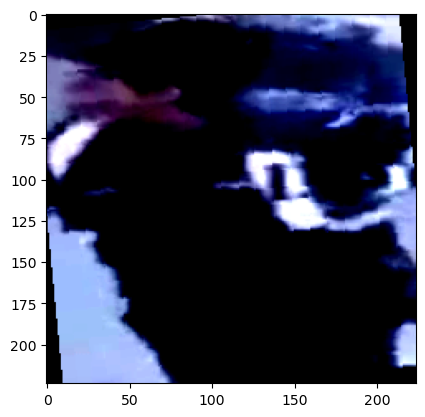

Predicted Label: image_NotViolence, True Label: image_NotViolence


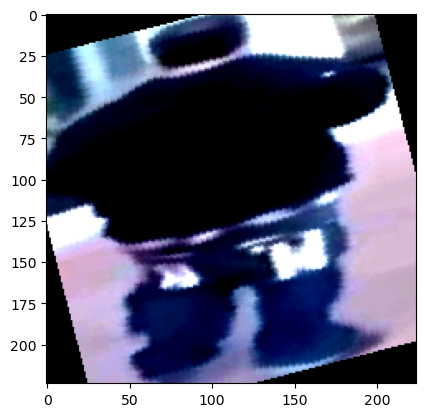

Predicted Label: image_NotViolence, True Label: image_NotViolence


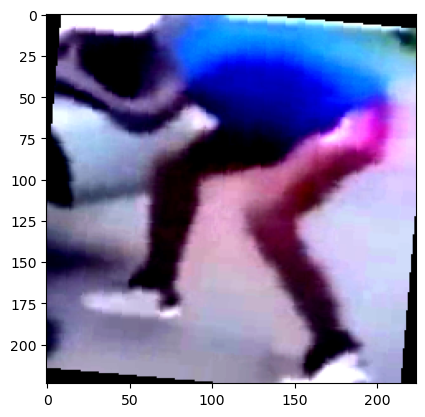

Predicted Label: image_Violence, True Label: image_NotViolence


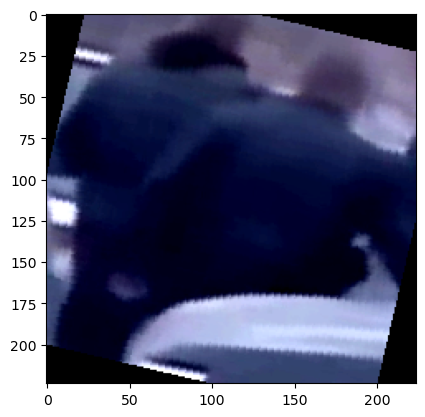

Predicted Label: image_NotViolence, True Label: image_NotViolence


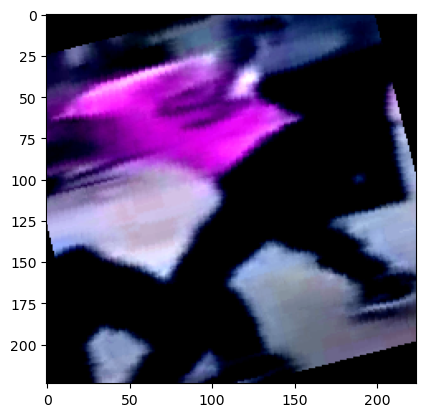

Predicted Label: image_Violence, True Label: image_Violence


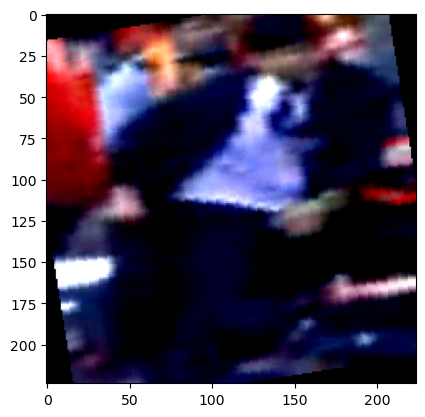

Predicted Label: image_NotViolence, True Label: image_NotViolence


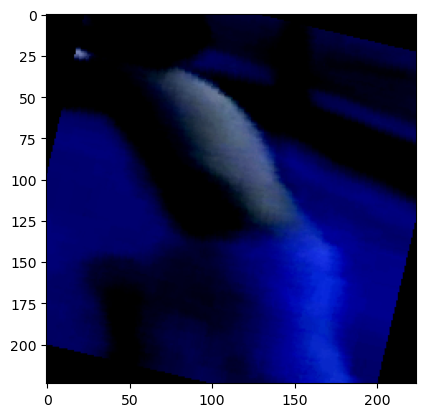

Predicted Label: image_NotViolence, True Label: image_Violence


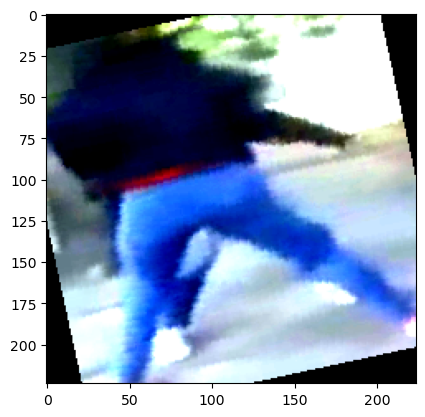

Predicted Label: image_Violence, True Label: image_NotViolence


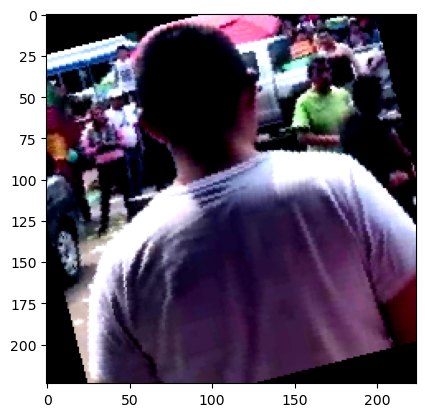

Predicted Label: image_Violence, True Label: image_NotViolence


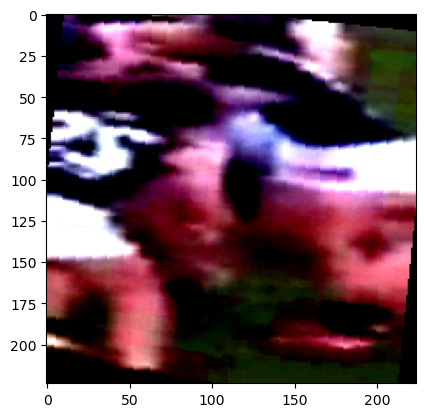

Predicted Label: image_NotViolence, True Label: image_Violence


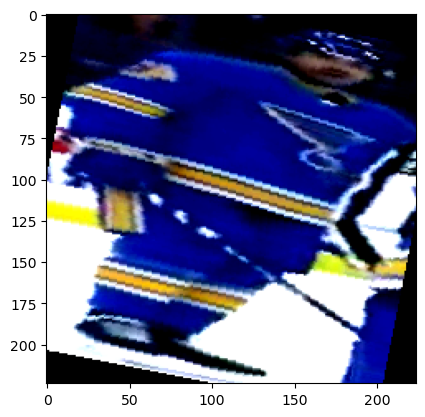

Predicted Label: image_NotViolence, True Label: image_NotViolence


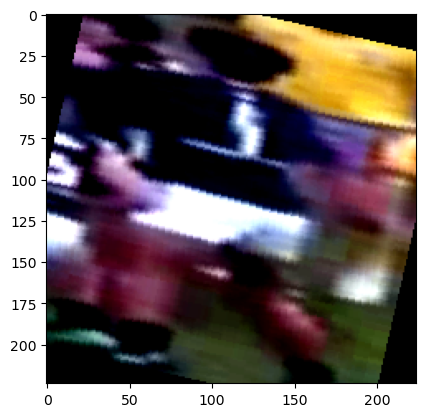

Predicted Label: image_NotViolence, True Label: image_Violence


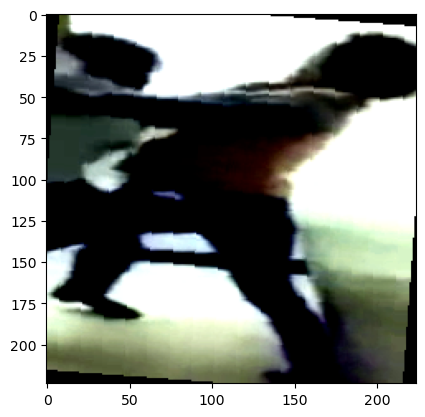

Predicted Label: image_Violence, True Label: image_Violence


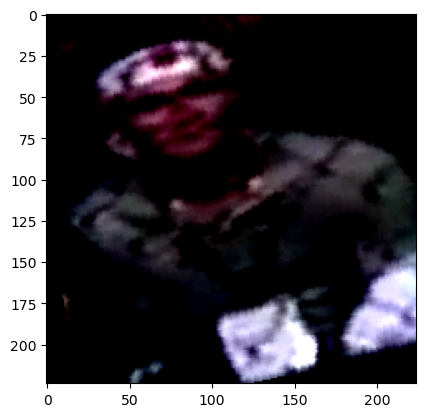

Predicted Label: image_NotViolence, True Label: image_NotViolence


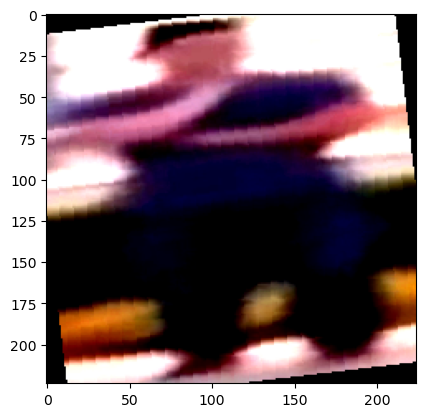

Predicted Label: image_NotViolence, True Label: image_NotViolence


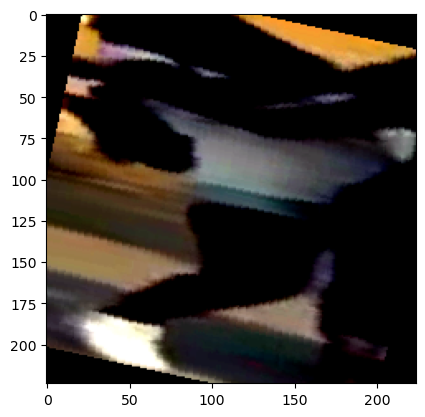

Predicted Label: image_NotViolence, True Label: image_Violence


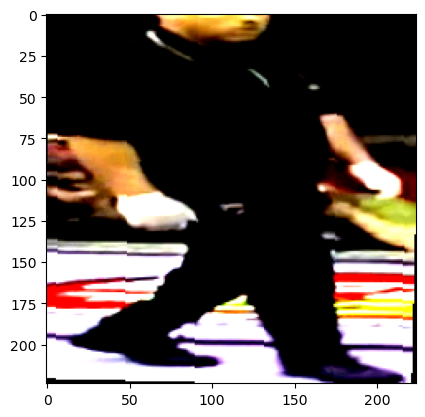

Predicted Label: image_NotViolence, True Label: image_NotViolence


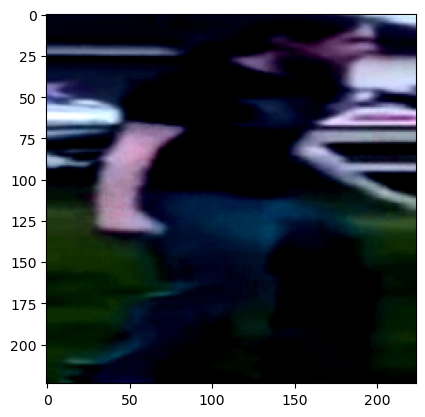

Predicted Label: image_NotViolence, True Label: image_NotViolence


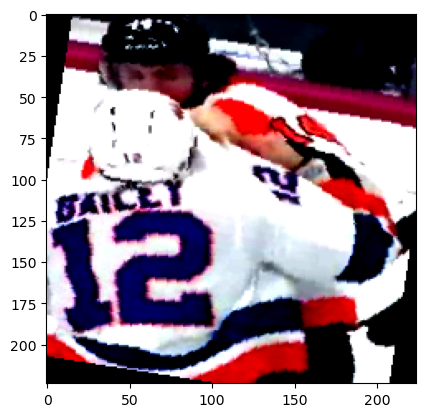

Predicted Label: image_Violence, True Label: image_Violence


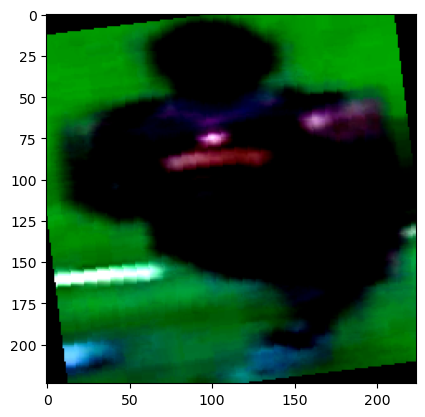

Predicted Label: image_NotViolence, True Label: image_NotViolence


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Определение функции для отображения изображений из тестового набора данных
def imshow(img):
    img = img / 2 + 0.5  # Денормализация изображения
    npimg = img.cpu().numpy()  # Преобразование в массив NumPy
    plt.imshow(np.transpose(npimg.squeeze(), (1, 2, 0)))  # Изменение порядка осей и удаление размерности пакета данных
    plt.show()

# Выбор случайных изображений из тестового набора данных
num_images_to_show = 20
indices = np.random.choice(len(test_loader.dataset), num_images_to_show, replace=False)

# Вывод изображений и соответствующих предсказанных и истинных меток
for i in indices:
    image, true_label = test_loader.dataset[i]
    image = image.unsqueeze(0).to(device)  # Добавление размерности пакета данных (batch dimension)
    output = model(image)
    _, predicted_label = torch.max(output, 1)
    
    predicted_label = class_name_in_str[predicted_label.item()]
    true_label = class_name_in_str[true_label.item()]

    # Отображение изображения
    imshow(image)

    # Вывод предсказанной и истинной меток
    print(f'Predicted Label: {predicted_label}, True Label: {true_label}')
